# The Modifiable Areal Unit Problem

Let's focus on comparing analysis results generated using different geographical representations of a phenonmena.

### Load relevant libraries

Documentation of these packages can be found at: 

-https://cran.r-project.org/web/packages/classInt/classInt.pdf

-https://cran.r-project.org/web/packages/rgdal/rgdal.pdf  

-https://cran.r-project.org/web/packages/spdep/spdep.pdf

-https://cran.r-project.org/web/packages/rgeos/rgeos.pdf

In [192]:
# Load relevant R packages
inLibraries = list('rgdal','raster','spdep','classInt','rgeos','repr','sp', 'RColorBrewer')
for (rpack in inLibraries) {
  if (is.element(rpack,installed.packages()[,1])){           
      #Load the library into R
      suppressMessages(library(rpack,character.only = TRUE))    }
    else {
        print(paste("Warning:  ",rpack," is not an installed package"))
    }
}
#resize plot area
options(repr.plot.width=6, repr.plot.height=6)

## Crime Analysis

This time, let's look at some crime data. There are a wide variety of sources of crime data that are publically available and easy to access. For instance, I did a websearch for crime data and found the city of Chicago posts current crimes in a .csv file format (Chicago Crime data https://catalog.data.gov/dataset/crimes-one-year-prior-to-present-e171f). There are actually a large amount of crimes in this dataset, so I took a subset (those reported for Oct. 2016). 

I created a point featureclass from the .csv file given it contained latitude/longitude fields (chicago/ChicagoCrimeOct2016.shp)

Some different polygon topologies have been provided for which the crime data can be aggregated (https://www.census.gov/geo/maps-data/data) 

Census tracts (chicago/centracts.shp), 

Census ZCTAs (chicago/cenZCTAs.shp), and 

transportation analysis zones (chicago/cttpTAZ.shp) 

(see http://ctpp.transportation.org/Pages/5-Year-Data.aspx for more info about TAZs). 

Also a boundary file for the study area is included (chicago/ChicagoOutlineB).

Read in the crime points, tract, ZCTA, TAZ and boundary polygon featureclasses. Note how the number of features in the summary polygon data differ from one another.

In [193]:
crime <- readOGR("/dsa/data/geospatial/DS8612/chicago","ChicagoCrimeOct2016")
census <- readOGR("/dsa/data/geospatial/DS8612/chicago","centracts")
censusZ <- readOGR("/dsa/data/geospatial/DS8612/chicago","cenZCTAs")
transport <- readOGR("/dsa/data/geospatial/DS8612/chicago","cttpTAZ")
boundary <- readOGR("/dsa/data/geospatial/DS8612/chicago","ChicagoOutlineB")

OGR data source with driver: ESRI Shapefile 
Source: "/dsa/data/geospatial/DS8612/chicago", layer: "ChicagoCrimeOct2016"
with 21679 features
It has 16 fields
OGR data source with driver: ESRI Shapefile 
Source: "/dsa/data/geospatial/DS8612/chicago", layer: "centracts"
with 1085 features
It has 194 fields
OGR data source with driver: ESRI Shapefile 
Source: "/dsa/data/geospatial/DS8612/chicago", layer: "cenZCTAs"
with 149 features
It has 194 fields
OGR data source with driver: ESRI Shapefile 
Source: "/dsa/data/geospatial/DS8612/chicago", layer: "cttpTAZ"
with 1614 features
It has 6 fields
OGR data source with driver: ESRI Shapefile 
Source: "/dsa/data/geospatial/DS8612/chicago", layer: "ChicagoOutlineB"
with 1 features
It has 1 fields


In [194]:
head(crime@data)

CASE_,DATE__OF_O,BLOCK,IUCR,PRIMARY_DE,SECONDARY,LOCATION_D,ARREST,DOMESTIC,BEAT,WARD,FBI_CD,X_COORDINA,Y_COORDINA,LATITUDE,LONGITUDE
HZ472453,2016/10/12,007XX W OHARE ST,1320,CRIMINAL DAMAGE,TO VEHICLE,AIRPORT EXTERIOR - SECURE AREA,N,N,1654,41,14,1096020,1938449,41.98790,-87.92221
HZ463490,2016/10/06,0000X W C17 ST,860,THEFT,RETAIL THEFT,SMALL RETAIL STORE,N,N,1651,41,6,1099330,1935025,41.97846,-87.91010
HZ491339,2016/10/27,006XX W OHARE ST,1812,NARCOTICS,POSS: CANNABIS MORE THAN 30GMS,AIRPORT EXTERIOR - NON-SECURE AREA,Y,N,1654,41,18,1100088,1926079,41.95390,-87.90747
HZ494135,2016/10/29,006XX W OHARE ST,460,BATTERY,SIMPLE,AIRPORT BUILDING NON-TERMINAL - NON-SECURE AREA,N,N,1654,41,0,1100088,1926079,41.95390,-87.90747
HZ479122,2016/10/08,115XX W TOUHY AVE,890,THEFT,FROM BUILDING,AIRPORT BUILDING NON-TERMINAL - NON-SECURE AREA,N,N,1654,41,6,1100260,1946117,42.00889,-87.90647
HZ464488,2016/10/02,0000X W TERMINAL ST,810,THEFT,OVER $500,AIRPORT BUILDING NON-TERMINAL - SECURE AREA,N,N,1651,41,6,1100317,1935229,41.97901,-87.90646


In [195]:
head(census@data)

,GEOID10,NAMELSAD10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,DP0010001,DP0010002,DP0010003,DP0010004,⋯,DP0200001,DP0210001,DP0210002,DP0210003,DP0220001,DP0220002,DP0230001,DP0230002,Shape_Leng,Shape_Area
0,17043842800,Census Tract 8428,2426524,6842,+41.8969327,-087.9271276,4503,287,356,378,⋯,5.4,1592,1368,224,4001,465,2.92,2.08,0.09077950,0.0002640016
1,17043840703,Census Tract 8407.03,2526939,83920,+41.9372257,-087.9300599,3898,236,224,225,⋯,5.9,1644,669,975,1856,2042,2.77,2.09,0.06856793,0.0002834433
2,17043840706,Census Tract 8407.06,3215956,140418,+41.9181215,-087.9250012,3307,185,222,229,⋯,0.9,1095,985,110,2903,404,2.95,3.67,0.08234755,0.0003642677
3,17043840705,Census Tract 8407.05,4880003,12123,+41.9216340,-087.9518395,3837,263,298,251,⋯,3.4,1234,1062,172,3086,591,2.91,3.44,0.10618516,0.0005309730
4,17043840704,Census Tract 8407.04,3357971,52062,+41.9411814,-087.9472043,3258,252,229,166,⋯,9.4,1117,497,620,1345,1908,2.71,3.08,0.07947556,0.0003701992
5,17043840000,Census Tract 8400,11754772,124997,+41.9784876,-087.9395607,2999,236,220,234,⋯,2.5,867,599,268,2058,941,3.44,3.51,0.14646122,0.0012904647


In [196]:
head(censusZ@data)

,ZCTA5CE10,GEOID10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,DP0010001,DP0010002,DP0010003,DP0010004,⋯,DP0200001,DP0210001,DP0210002,DP0210003,DP0220001,DP0220002,DP0230001,DP0230002,Shape_Leng,Shape_Area
0,60005,60005,16979978,104883,+42.0644900,-087.9854615,29308,1789,1822,1654,⋯,9.2,12635,8684,3951,21574,7524,2.48,1.90,0.4002969,0.001858384
1,60007,60007,36460145,946066,+42.0086501,-087.9973604,33820,1650,1711,2109,⋯,7.7,13558,10456,3102,27042,6646,2.59,2.14,0.4886727,0.004065263
2,60008,60008,13389228,11945,+42.0697858,-088.0162210,22717,1620,1376,1384,⋯,8.6,8433,6212,2221,15886,6506,2.56,2.93,0.3741267,0.001457932
3,60016,60016,27518585,251245,+42.0495801,-087.8949996,59690,3685,3079,3018,⋯,9.2,23605,16513,7092,41831,17119,2.53,2.41,0.4113549,0.003019964
4,60018,60018,42345213,656169,+41.9793883,-087.9117630,30099,1935,2059,1974,⋯,8.8,10361,7583,2778,22392,7291,2.95,2.62,0.3868386,0.004672606
5,60025,60025,29799274,262577,+42.0752009,-087.8210259,39105,2088,2825,2941,⋯,6.4,14818,12303,2515,32756,6155,2.66,2.45,0.4416421,0.003270523


In [197]:
head(transport@data)

,ctpp_id,label,name,geoid,F0,F1
0,C1300US1719742326098,1719742326098,"TAZ 42326098, Will County, Illinois",1719742326098,2720,230
1,C1300US1704342096415,1704342096415,"TAZ 42096415, DuPage County, Illinois",1704342096415,2270,316
2,C1300US1704342246410,1704342246410,"TAZ 42246410, DuPage County, Illinois",1704342246410,1975,350
3,C1300US1704342166401,1704342166401,"TAZ 42166401, DuPage County, Illinois",1704342166401,1195,207
4,C1300US1704341886480,1704341886480,"TAZ 41886480, DuPage County, Illinois",1704341886480,1615,391
5,C1300US1704342076393,1704342076393,"TAZ 42076393, DuPage County, Illinois",1704342076393,2425,350


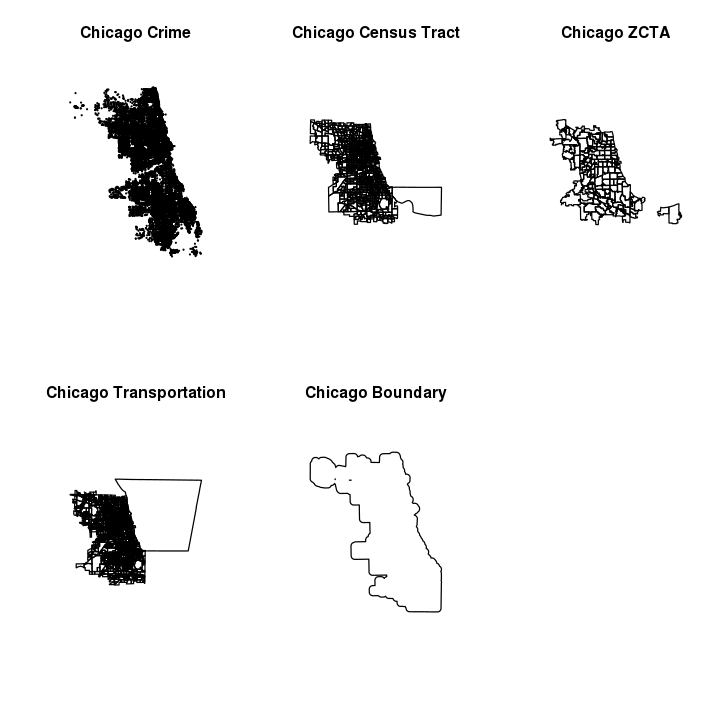

In [198]:
par(mfrow=c(2,3))

plot(crime, main = "Chicago Crime", cex = 0.2, pch = 20)
plot(census, main = "Chicago Census Tract")
plot(censusZ, main = "Chicago ZCTA")
plot(transport, main = "Chicago Transportation")
plot(boundary, main = "Chicago Boundary")

Given that the summary polygon datasets span a region larger than the extent of the reported crime data, you should refine the set of polygons that will be retained for analysis. 

This is why the boundary file for Chicago is provided.  Use the boundary features to select tract, ZCTA, and TAZ polygons that are contained within the Chicago community (inside the boundary polygon provided). 

In [199]:
getContainedPoly <- function(boundary, p){    
    int <- overGeomGeom(boundary, p, returnList = TRUE, fn = NULL)
    
    i <- 1
    containedList <- list()
    
    for (subsel in int){
        for(ele in subsel){
            if (gContains(boundary, p[ele, ], byid = FALSE, prepared = TRUE, 
                             returnDense = TRUE, STRsubset = FALSE, checkValidity = FALSE)){
                containedList[[i]] <- ele
                i <- i + 1
            }
        }
    }
    
    conSet <- unlist(containedList)
    conFeat <- p[conSet, ]
    
    plot(boundary)
    plot(conFeat, col = "lightblue", add = TRUE) 
    return(conFeat)
}

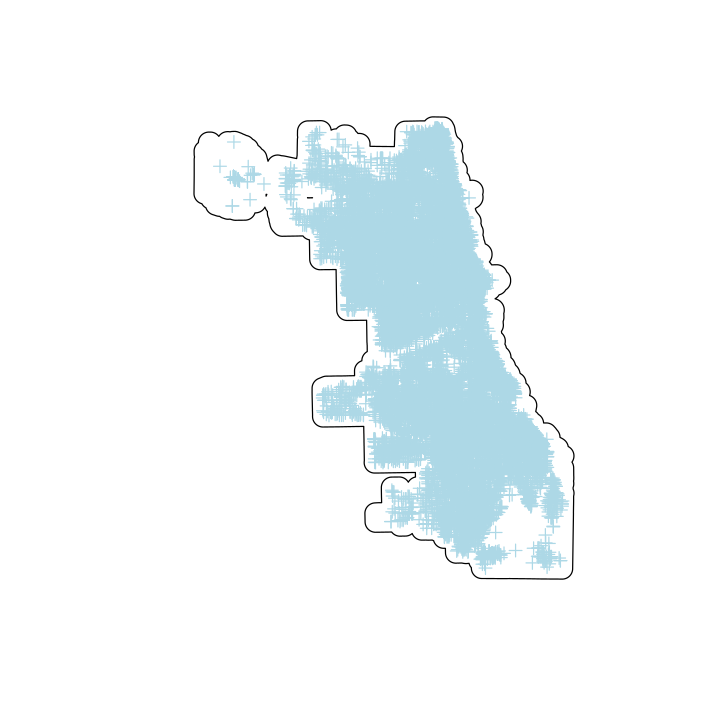

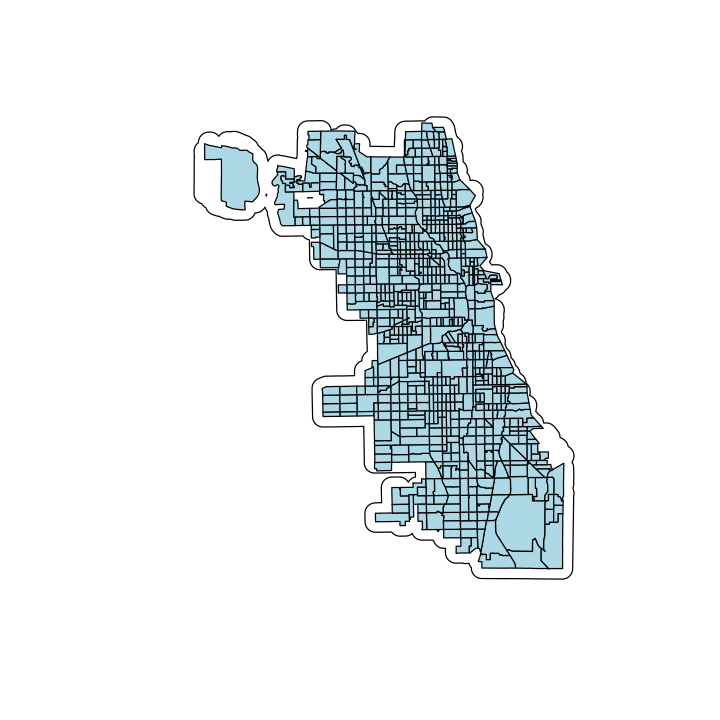

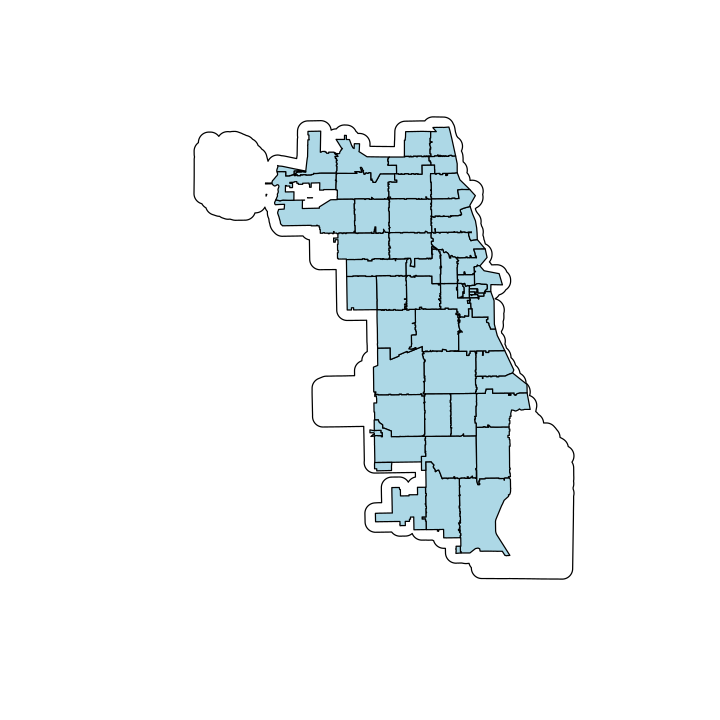

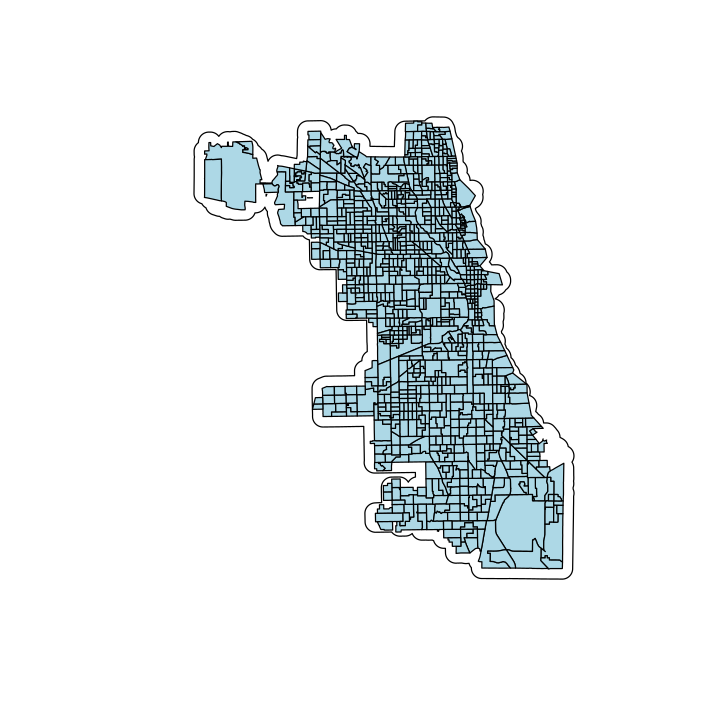

In [200]:
polys <- c(crime, census, censusZ, transport)
newPolys <- list()

i <- 1

for(p in polys){
    newPoly <- getContainedPoly(boundary, p)
    newPolys[[i]] <- newPoly
    i <- i + 1
}

In [201]:
length(newPolys)

[1] 4

In [202]:
# retrieve the new intersected crime, census, censusZ, transport polygons

crimeInt <- newPolys[[1]]
censusInt <- newPolys[[2]]
censusZInt <- newPolys[[3]]
transportInt <- newPolys[[4]]

Attribute the point features with number of crimes at each location (which will be one) and the number of THEFT cases at each location (will be one in case the crime was theft, zero otherwise.

In [203]:
head(crimeInt@data, 2)

CASE_,DATE__OF_O,BLOCK,IUCR,PRIMARY_DE,SECONDARY,LOCATION_D,ARREST,DOMESTIC,BEAT,WARD,FBI_CD,X_COORDINA,Y_COORDINA,LATITUDE,LONGITUDE
HZ472453,2016/10/12,007XX W OHARE ST,1320,CRIMINAL DAMAGE,TO VEHICLE,AIRPORT EXTERIOR - SECURE AREA,N,N,1654,41,14,1096020,1938449,41.98790,-87.92221
HZ463490,2016/10/06,0000X W C17 ST,860,THEFT,RETAIL THEFT,SMALL RETAIL STORE,N,N,1651,41,6,1099330,1935025,41.97846,-87.91010


In [204]:
crimeInt@data$NumCrime <- 1
crimeInt@data$NumTheft <- ifelse(crimeInt@data$PRIMARY_DE == 'THEFT', 1, 0)

head(crimeInt@data, 3)

CASE_,DATE__OF_O,BLOCK,IUCR,PRIMARY_DE,SECONDARY,LOCATION_D,ARREST,DOMESTIC,BEAT,WARD,FBI_CD,X_COORDINA,Y_COORDINA,LATITUDE,LONGITUDE,NumCrime,NumTheft
HZ472453,2016/10/12,007XX W OHARE ST,1320,CRIMINAL DAMAGE,TO VEHICLE,AIRPORT EXTERIOR - SECURE AREA,N,N,1654,41,14,1096020,1938449,41.98790,-87.92221,1,0
HZ463490,2016/10/06,0000X W C17 ST,860,THEFT,RETAIL THEFT,SMALL RETAIL STORE,N,N,1651,41,6,1099330,1935025,41.97846,-87.91010,1,1
HZ491339,2016/10/27,006XX W OHARE ST,1812,NARCOTICS,POSS: CANNABIS MORE THAN 30GMS,AIRPORT EXTERIOR - NON-SECURE AREA,Y,N,1654,41,18,1100088,1926079,41.95390,-87.90747,1,0


Add a new, unique sequential integer index attribute to each of the three topologies (tract, zcta, and taz). 

In [205]:
tops <- c(censusInt, censusZInt, transportInt)
res <- list()

i <- 1

for (t in tops){
    t@data$uniqueid <- seq.int(nrow(t@data))
    res[[i]] <- t
    i <- i + 1
}

# remap them back to their variables
censusInt <- res[[1]]
censusZInt <- res[[2]]
transportInt <- res[[3]]

In [206]:
head(censusInt@data, 3)

,GEOID10,NAMELSAD10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,DP0010001,DP0010002,DP0010003,DP0010004,⋯,DP0210001,DP0210002,DP0210003,DP0220001,DP0220002,DP0230001,DP0230002,Shape_Leng,Shape_Area,uniqueid
13,17031840300,Census Tract 8403,831224,0,+41.8320943,-087.6818822,3950,289,281,299,⋯,1173,700,473,2456,1494,3.51,3.16,0.05000424,9.009214e-05,1
14,17031840200,Census Tract 8402,831087,0,+41.8445748,-087.6491915,2338,166,148,131,⋯,771,408,363,1338,997,3.28,2.75,0.04752789,9.009521e-05,2
15,17031841100,Census Tract 8411,1143247,0,+41.8510058,-087.6350978,7254,349,316,369,⋯,2621,1039,1582,3001,4251,2.89,2.69,0.04833201,1.239465e-04,3


In [207]:
head(censusZInt@data, 3)

,ZCTA5CE10,GEOID10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,DP0010001,DP0010002,DP0010003,DP0010004,⋯,DP0210001,DP0210002,DP0210003,DP0220001,DP0220002,DP0230001,DP0230002,Shape_Leng,Shape_Area,uniqueid
55,60456,60456,1240336,0,+41.7312484,-087.7311338,4349,216,256,325,⋯,1848,1495,353,3632,713,2.43,2.02,0.05327926,1.342256e-04,1
78,60601,60601,999363,0,+41.8853104,-087.6221295,11110,329,152,107,⋯,6739,2365,4374,3978,6564,1.68,1.50,0.05777077,1.084041e-04,2
79,60602,60602,225435,0,+41.8830726,-087.6291494,1204,28,16,10,⋯,569,293,276,507,452,1.73,1.64,0.02889667,2.445289e-05,3


In [208]:
head(transportInt@data, 3)

,ctpp_id,label,name,geoid,F0,F1,uniqueid
29,C1300US1704342296475,1704342296475,"TAZ 42296475, DuPage County, Illinois",1704342296475,25,41,1
58,C1300US1703143906493,1703143906493,"TAZ 43906493, Cook County, Illinois",1703143906493,3365,412,2
59,C1300US1703144006380,1703144006380,"TAZ 44006380, Cook County, Illinois",1703144006380,2350,648,3


Aggregate the point data to the polygon level for each of the three topologies (tract,zcta, and taz). 

In the end, for each polygon you should know the number of theft event, the total number of crimes as well as the theft rate. 

In [209]:
tops <- c(censusInt, censusZInt, transportInt)
length(tops)

[1] 3

In [210]:
nrow(censusInt@data)

[1] 810

In [211]:
i <- 1
res <- list()

for (t in tops){
    
    crime <- crimeInt
    
    overCrime <- over(crime, t)
    crime@data$utrackid <- overCrime$uniqueid
    retained <- c("NumCrime", "NumTheft", "utrackid")
    polyevents <- crime@data[retained]  
    
    polyevents[] <- lapply(polyevents, function(x) {
        type.convert(as.character(x))
    })

    aggEvents <- aggregate(polyevents, by = list(polyevents$utrackid), FUN = sum)
    BTracts <- merge(t@data, aggEvents, by.x = "uniqueid", by.y = "Group.1", all = TRUE)  
    ordered <- BTracts[order(BTracts$uniqueid), ]    
    ordered$TheftRate <- ordered$NumTheft / ordered$NumCrime
    ordered$TheftRate[is.na(ordered$TheftRate)] <- 0
    
    t@data$NumTheft <- ordered$NumTheft
    t@data$NumCrime <- ordered$NumCrime
    t@data$TheftRate <- ordered$TheftRate
    
    res[[i]] <- t
    
    i <- i + 1
}

In [212]:
length(res)

[1] 3

In [213]:
censusRes <- res[[1]]
censusZRes <- res[[2]]
transportRes <- res[[3]]

Map the theft rate for the three different topologies.

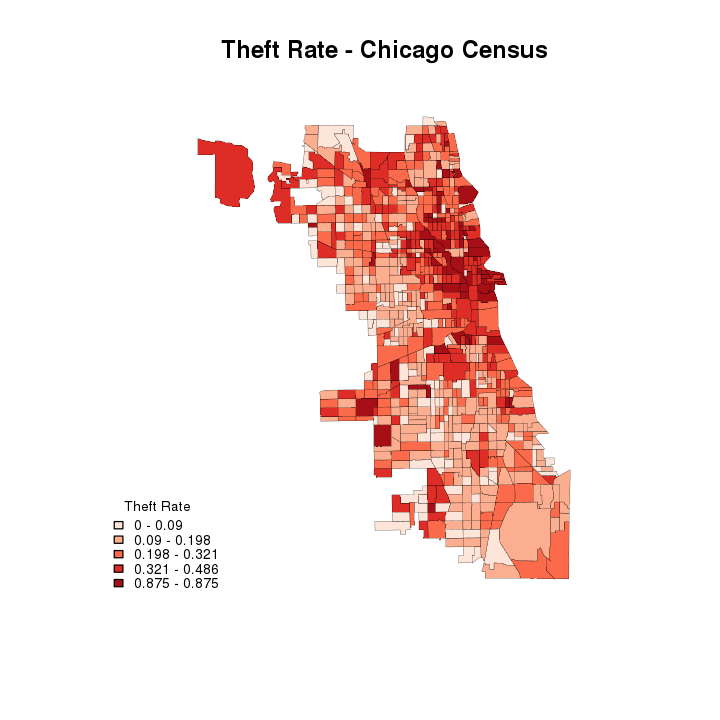

In [214]:
numcat <- 5
cate <- classIntervals(censusRes@data$TheftRate, numcat, style = "kmeans")

pal <- brewer.pal(numcat, "Reds")
cols <- findColours(cate, pal)

plot(censusRes, col = cols, lwd = 0.2, main = "Theft Rate - Chicago Census")
brks <- round(cate$brks, 3)
leg.text <- paste(brks[-numcat], brks[-1], sep = " - ")
legend("bottomleft", fill = attr(cols,"palette"), legend = leg.text, bty = "n", title = "Theft Rate", cex = 0.7)

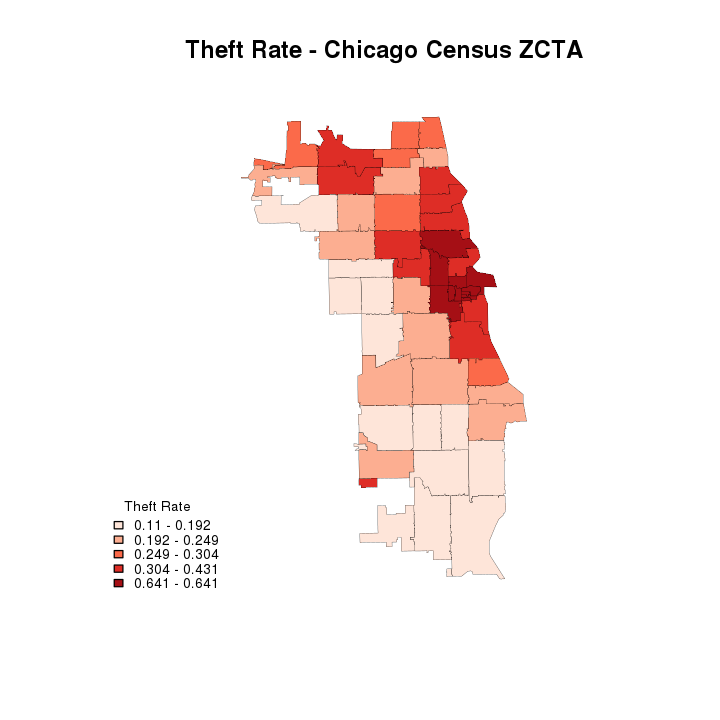

In [215]:
numcat <- 5
cate <- classIntervals(censusZRes@data$TheftRate, numcat, style = "kmeans")

pal <- brewer.pal(numcat, "Reds")
cols <- findColours(cate, pal)

plot(censusZRes, col = cols, lwd = 0.2, main = "Theft Rate - Chicago Census ZCTA")
brks <- round(cate$brks, 3)
leg.text <- paste(brks[-numcat], brks[-1], sep = " - ")
legend("bottomleft", fill = attr(cols,"palette"), legend = leg.text, bty = "n", title = "Theft Rate", cex = 0.7)

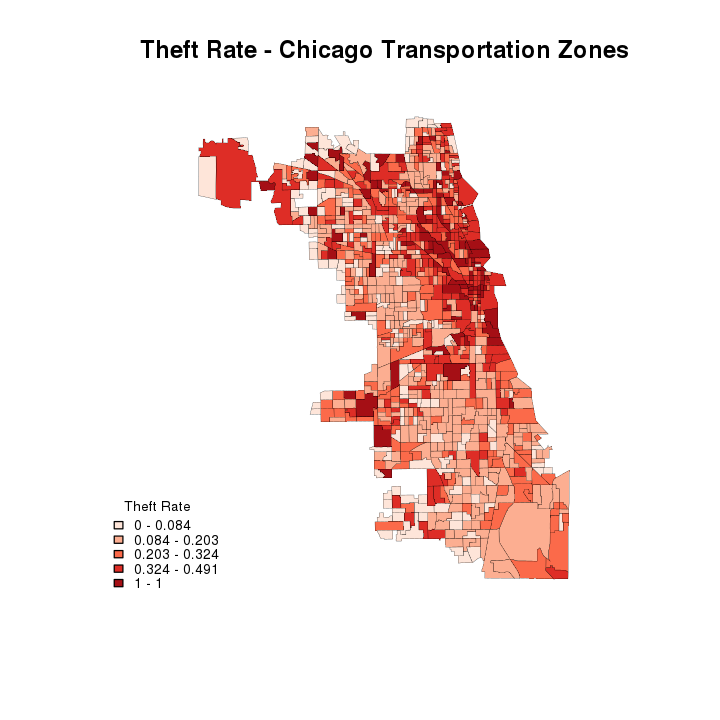

In [216]:
numcat <- 5
cate <- classIntervals(transportRes@data$TheftRate, numcat, style = "kmeans")

pal <- brewer.pal(numcat, "Reds")
cols <- findColours(cate, pal)

plot(transportRes, col = cols, lwd = 0.2, main = "Theft Rate - Chicago Transportation Zones")
brks <- round(cate$brks, 3)
leg.text <- paste(brks[-numcat], brks[-1], sep = " - ")
legend("bottomleft", fill = attr(cols,"palette"), legend = leg.text, bty = "n", title = "Theft Rate", cex = 0.7)

Generate a spdep neighborhood object for each of the 3 topologies. 

Use the Queen's criterion. 

In [220]:
# censusRes

census.nb <- poly2nb(censusRes, queen = TRUE)
censusRes <- censusRes[card(census.nb) >= 1, ]

census.nb <- poly2nb(censusRes, queen = TRUE)
census.listw <- nb2listw(census.nb, style = "W")

census.nb.self <- include.self(census.nb)
census.listb.self <- nb2listw(census.nb.self, style = "B")

head(census.nb)

[[1]]
[1]  95  97 221 237 654 689 691 692 725

[[2]]
[1]   3  97 135 222 694 695 724

[[3]]
[1]   2  97 107 222 223 332 333 334 337

[[4]]
[1]  97 106 110 236 237 264 303 800

[[5]]
[1]  15  16  17 106 794 795

[[6]]
[1] 244 277 283 284 310 311 312

In [221]:
# censusZRes

censusZ.nb <- poly2nb(censusZRes, queen = TRUE)
censusZRes <- censusZRes[card(censusZ.nb) >= 1, ]

censusZ.nb <- poly2nb(censusZRes, queen = TRUE)
censusZ.listw <- nb2listw(censusZ.nb, style = "W")

censusZ.nb.self <- include.self(censusZ.nb)
censusZ.listb.self <- nb2listw(censusZ.nb.self, style = "B")

head(censusZ.nb)

[[1]]
[1] 45

[[2]]
[1]  3  4  6  7 12 47

[[3]]
[1] 2 4 7

[[4]]
[1] 2 3 5 6 7

[[5]]
[1] 4 6 7 8

[[6]]
[1]  2  4  5  8 12 17

In [222]:
# transportRes

transport.nb <- poly2nb(transportRes, queen = TRUE)
transportRes <- transportRes[card(transport.nb) >= 1, ]

transport.nb <- poly2nb(transportRes, queen = TRUE)
transport.listw <- nb2listw(transport.nb, style = "W")

transport.nb.self <- include.self(transport.nb)
transport.listb.self <- nb2listw(transport.nb.self, style = "B")

head(transport.nb)

[[1]]
[1] 313

[[2]]
[1]  23  94 206

[[3]]
[1] 222 324 355 852 910

[[4]]
[1]  62  63 132 133 236 502

[[5]]
[1]  21  97 205 206 273 293 568

[[6]]
[1] 349 350 390 434 720

Compute the local Moran statistic for the two.sided hypothesis for the theft rate variable for each of the 3 topologies. 

Retrieve the z-score and the p-value for each feature.  


In [223]:
census.lm <- localmoran(censusRes@data$TheftRate, 
                            census.listw, 
                            alternative = "two.sided")

head(census.lm)

census.zscore <- census.lm[, 4] # Z-Score
census.pval <- census.lm[, 5] # p-value

,Ii,E.Ii,Var.Ii,Z.Ii,Pr(z != 0)
13,-0.57327750,-0.001237624,0.1096633,-1.7274113,8.409383e-02
14,0.95683208,-0.001237624,0.1413474,2.5483155,1.082445e-02
15,1.32056526,-0.001237624,0.1096633,3.9915000,6.565668e-05
16,0.37116332,-0.001237624,0.1235251,1.0595787,2.893363e-01
17,0.04628377,-0.001237624,0.1651105,0.1169504,9.068993e-01
18,-0.06770603,-0.001237624,0.1413474,-0.1767956,8.596690e-01


In [224]:
censusZ.lm <- localmoran(censusZRes@data$TheftRate,
                            censusZ.listw, 
                            alternative = "two.sided")

head(censusZ.lm)

censusZ.zscore <- censusZ.lm[, 4]
censusZ.pval <- censusZ.lm[, 5]

,Ii,E.Ii,Var.Ii,Z.Ii,Pr(z != 0)
55,-0.1453357,-0.01923077,0.9680869,-0.1281666,8.980172e-01
78,3.0190552,-0.01923077,0.1460448,7.9503375,1.860041e-15
79,4.1148078,-0.01923077,0.3104532,7.4195305,1.175363e-13
80,2.0848214,-0.01923077,0.1789265,4.9741533,6.553343e-07
81,1.7383691,-0.01923077,0.2282490,3.6788793,2.342611e-04
82,0.7114050,-0.01923077,0.1460448,1.9118677,5.589316e-02


In [225]:
transport.lm <- localmoran(transportRes@data$TheftRate, 
                              transport.listw,
                              alternative = "two.sided")

head(transport.lm)

transport.zscore <- transport.lm[, 4]
transport.pval <- transport.lm[, 5]

,Ii,E.Ii,Var.Ii,Z.Ii,Pr(z != 0)
29,-1.38859908,-0.0009596929,0.9967656,-1.38988894,0.1645626
58,-0.03198013,-0.0009596929,0.3316189,-0.05386768,0.9570406
59,0.39571022,-0.0009596929,0.1985896,0.89012503,0.3733988
60,-0.03113028,-0.0009596929,0.1653323,-0.07420018,0.9408511
62,-0.24818502,-0.0009596929,0.1415770,-0.65704720,0.5111506
63,0.69463297,-0.0009596929,0.1985896,1.56090599,0.1185459


Compute the z-scores associated with the 0.90, 0.95, and 0.995 confidence levels assuming a normal distribution. 

Map the normal distribution z-scores based on the three confidence level intervals for the Moran statistic. 

[1] "0.9 1.64485362695147"   "0.95 1.95996398454005"  "0.995 2.80703376834381"

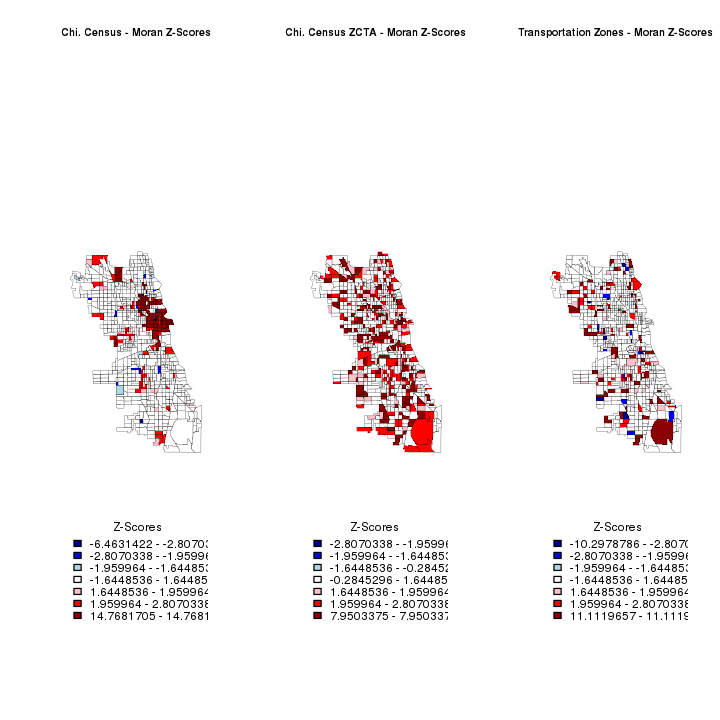

In [251]:
par(mfrow=c(1,3))

# Census

zNormal <- list()

probsU <- c(0.90, 0.95, 0.995)
i <- 1

for (pr in probsU){
    inpr <- 1 - ((1 - pr) / 2)
    errorZ <- qnorm(inpr, lower.tail = TRUE)
    zNormal[[i]] <- 0 + errorZ
    i <- i + 1
}

zM <- unlist(zNormal)
paste(probsU, zM, sep = " ")

ncz1 <- 4 + length(zM) - 1
ncz2 <- 4 + length(zM)

zM.MIi <- classIntervals(census.zscore, n = ncz1,
                            style = "fixed", 
                            fixedBreaks = c(min(census.zscore), -zM, zM, max(census.zscore)))

pal <- c("navy", "blue", "lightblue", "white", "pink", "red", "darkred")
cols <- findColours(zM.MIi, pal)

plot(censusRes, col = cols, lwd = 0.2, main = "Chi. Census - Moran Z-Scores", cex.main = 0.8)
brks <- round(zM.MIi$brks, ncz2)
leg <- paste(brks[-ncz2], brks[-1], sep = " - ")
legend("bottomleft", fill = pal, legend = leg, bty = "n", title = "Z-Scores", cex = 0.9)

## ==============================================================================================================

# CensusZCTA

zNormal <- list()

probsU <- c(0.90, 0.95, 0.995)
i <- 1

for (pr in probsU){
    inpr <- 1 - ((1 - pr) / 2)
    errorZ <- qnorm(inpr, lower.tail = TRUE)
    zNormal[[i]] <- 0 + errorZ
    i <- i + 1
}

zM <- unlist(zNormal)

ncz1 <- 4 + length(zM) - 1
ncz2 <- 4 + length(zM)

zM.MIi <- classIntervals(censusZ.zscore, n = ncz1,
                            style = "fixed", 
                            fixedBreaks = c(min(censusZ.zscore), -zM, zM, max(censusZ.zscore)))

pal <- c("navy", "blue", "lightblue", "white", "pink", "red", "darkred")
cols <- findColours(zM.MIi, pal)

plot(censusRes, col = cols, lwd = 0.2, main = "Chi. Census ZCTA - Moran Z-Scores", cex.main = 0.8)
brks <- round(zM.MIi$brks, ncz2)
leg <- paste(brks[-ncz2], brks[-1], sep = " - ")
legend("bottomleft", fill = pal, legend = leg, bty = "n", title = "Z-Scores", cex = 0.9)

## ==============================================================================================================

# Transportation Zones

zNormal <- list()

probsU <- c(0.90, 0.95, 0.995)
i <- 1

for (pr in probsU){
    inpr <- 1 - ((1 - pr) / 2)
    errorZ <- qnorm(inpr, lower.tail = TRUE)
    zNormal[[i]] <- 0 + errorZ
    i <- i + 1
}

zM <- unlist(zNormal)

ncz1 <- 4 + length(zM) - 1
ncz2 <- 4 + length(zM)

zM.MIi <- classIntervals(transport.zscore, n = ncz1,
                            style = "fixed", 
                            fixedBreaks = c(min(transport.zscore), -zM, zM, max(transport.zscore)))

pal <- c("navy", "blue", "lightblue", "white", "pink", "red", "darkred")
cols <- findColours(zM.MIi, pal)

plot(censusRes, col = cols, lwd = 0.2, main = "Transportation Zones - Moran Z-Scores", cex.main = 0.8)
brks <- round(zM.MIi$brks, ncz2)
leg <- paste(brks[-ncz2], brks[-1], sep = " - ")
legend("bottomleft", fill = pal, legend = leg, bty = "n", title = "Z-Scores", cex = 0.9)